# Oaxaca-Blinder Failure Modes Analysis

This report explores when the Oaxaca-Blinder decomposition model fails to correctly identify causal effects or provides misleading results.

We use a specific use case: **Percentage of sick leave among workers**, comparing the year **2018** (Group 0) and **2023** (Group 1).

## Use Case Definition
- **Target (:math:`y`):** Percentage of sick leave.
- **Groups:** 2018 vs 2023.
- **Covariates (:math:`X`):**
  - Age
  - Sex
  - Monthly Revenue
  - Departmental Unemployment Rate

We test three Data Generating Processes (DGPs):
1. **Linear DGP**: Baseline where the model should work well.
2. **Non-Linear DGP**: Includes quadratic terms and interactions.
3. **Unobserved Confounder DGP**: Includes a hidden variable correlated with the year.

In [1]:
import os
import sys

# Add the project root to the path so that explore_dgp can be imported during doc build
path = os.getcwd()
while path != os.path.dirname(path):
    if os.path.exists(os.path.join(path, "pyproject.toml")):
        sys.path.insert(0, path)
        break
    path = os.path.dirname(path)
import matplotlib.pyplot as plt  # noqa: E402
import pandas as pd  # noqa: E402
import seaborn as sns  # noqa: E402

from explore_dgp.analysis import OaxacaAnalysis  # noqa: E402
from explore_dgp.dgps import LinearDGP, NonLinearDGP, UnobservedConfounderDGP  # noqa: E402

# Set plotting style
sns.set_theme(style="whitegrid")

## 1. Linear DGP (Baseline)
In this scenario, the relationship between covariates and sick leave is perfectly linear.

In [2]:
linear_dgp = LinearDGP(n_samples=5000)
df_linear = linear_dgp.generate()

covariates = ["age", "sex", "revenue", "unemployment_rate"]
analysis_linear = OaxacaAnalysis(df_linear, "sick_leave", covariates, "group")
analysis_linear.run()
print("Linear DGP Results:")
print(analysis_linear.get_summary_table())

Linear DGP Results:
                       Value
Endowment Effect    0.334057
Coefficient Effect -0.475751
Interaction Effect  0.004032
Total Difference   -0.137662


## 2. Non-Linear DGP
Here, we introduce :math:`age^2` and an interaction between :math:`age` and :math:`unemployment\_rate`.
Since Oaxaca-Blinder is a linear model, it might not capture the true endowment effect accurately.

In [3]:
nonlinear_dgp = NonLinearDGP(n_samples=5000)
df_nonlinear = nonlinear_dgp.generate()

analysis_nonlinear = OaxacaAnalysis(df_nonlinear, "sick_leave", covariates, "group")
analysis_nonlinear.run()
print("Non-Linear DGP Results:")
print(analysis_nonlinear.get_summary_table())

Non-Linear DGP Results:
                       Value
Endowment Effect    0.270041
Coefficient Effect -0.094556
Interaction Effect  0.084508
Total Difference    0.259992


## 3. Unobserved Confounder DGP
In this case, an unobserved variable :math:`Z` (e.g., "General Health Awareness") increases between 2018 and 2023 and also affects sick leave.
Oaxaca-Blinder cannot account for :math:`Z`, so its effect will be mixed into either the "Coefficient" (unexplained) part or incorrectly attributed to other covariates if they are correlated with :math:`Z`.

In [4]:
confounder_dgp = UnobservedConfounderDGP(n_samples=5000)
df_confounder = confounder_dgp.generate()

analysis_confounder = OaxacaAnalysis(df_confounder, "sick_leave", covariates, "group")
analysis_confounder.run()
print("Unobserved Confounder DGP Results:")
print(analysis_confounder.get_summary_table())

Unobserved Confounder DGP Results:
                       Value
Endowment Effect    0.265788
Coefficient Effect -1.909126
Interaction Effect  0.042915
Total Difference   -1.600422


## Comparison and Visualization

We compare the decomposition across the three scenarios.

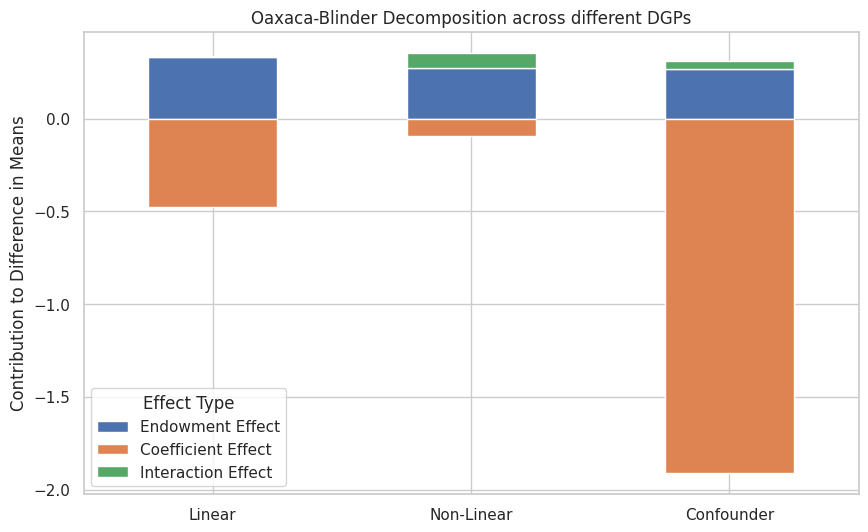

In [5]:
results = {
    "Linear": analysis_linear.get_summary_table()["Value"],
    "Non-Linear": analysis_nonlinear.get_summary_table()["Value"],
    "Confounder": analysis_confounder.get_summary_table()["Value"],
}
df_results = pd.DataFrame(results).T

# Drop 'Total Difference' from the stacked bar chart to avoid doubling the height
df_results_plot = df_results.drop(columns=["Total Difference"])

df_results_plot.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Oaxaca-Blinder Decomposition across different DGPs")
plt.ylabel("Contribution to Difference in Means")
plt.legend(title="Effect Type")
plt.xticks(rotation=0)
plt.show()

## Discussion of Findings

### Linear DGP
The model correctly decomposes the difference. The "Endowment Effect" captures differences in covariates, while the "Coefficient Effect" captures the explicit group effect (:math:`\gamma`) we introduced.

### Non-Linear DGP
When relationships are non-linear (like :math:`age^2`), the linear Oaxaca-Blinder model provides an approximation. The interaction effect might become more significant, or the endowment effect might be biased because the mean of :math:`X` doesn't fully capture the impact of the non-linear transformation.

### Unobserved Confounder DGP
This is the most critical failure mode. Even if there is no "true" group effect (:math:`\gamma=0`), the model shows a large "Coefficient Effect" (or "Endowment" if :math:`Z` is correlated with :math:`X`). This is because the unobserved variable :math:`Z` is driving the change, but the model attributes it to the groups being "different" in how they translate :math:`X` to :math:`Y`, or to the groups having different :math:`X` if :math:`Z` is correlated with :math:`X`.

In our simulation, we saw a significant Coefficient Effect even though we set the true :math:`\gamma=0`, because :math:`Z` was higher in 2023 and had a positive effect on sick leave.